In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices('GPU'))

import random
import pickle
import spacy

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import sys
sys.path.append('..')
import ui_utils
import nlp_tools

## Create function to turn multilabel tags into dummies

In [3]:
train_df = pd.read_json('../input/test_train_input.json', orient='records')

In [4]:
train_df.head()

,Text,UID,Tags
0,Well the title says it all! If you want a ligh...,0,"A, C"
1,I can't believe this item was even approved by...,1,B
2,Roland smoked eel fillets are absolutely delic...,2,"A, B"
3,The product is fresh and tasty. Its also not e...,3,B
4,Switch Orange/Tangerine soda comes in a smalle...,4,A


In [5]:
ui_utils.create_tag_columns(train_df).head()

,Text,UID,Tags,Tag_A,Tag_B,Tag_C
0,Well the title says it all! If you want a ligh...,0,"A, C",1,0,1
1,I can't believe this item was even approved by...,1,B,0,1,0
2,Roland smoked eel fillets are absolutely delic...,2,"A, B",1,1,0
3,The product is fresh and tasty. Its also not e...,3,B,0,1,0
4,Switch Orange/Tangerine soda comes in a smalle...,4,A,1,0,0


In [6]:
train_df = ui_utils.create_tag_columns(train_df)

## Tokenize and generate text for training

Create functions that handle a binary classification

In [7]:
target = 'Tag_A'
BATCH_SIZE = 100
BUFFER_SIZE = 1000

In [8]:
tokenizer, text_seqs = nlp_tools.train_tokenizer(train_df)
target_list = train_df.loc[:, target].tolist()

In [9]:
# TODO: incorporate time stamp
with open('../output/text_tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

In [10]:
def data_split(text_seqs, target_list, test_rate=0.1):
    test_count = round(len(text_seqs) * test_rate)
    print(f"Out of {len(text_seqs):,} samples, {test_count:,} will be used as test samples")
    test_index = np.random.choice(len(text_seqs), test_count)
    print(test_index)
    train_index = [idx for idx in range(len(text_seqs)) if idx not in test_index]
    text_seqs, target_list = np.array(text_seqs), np.array(target_list)
    test_seqs, test_targets = text_seqs[test_index], target_list[test_index]
    train_seqs, train_targets = text_seqs[train_index], target_list[train_index]
    return test_seqs, test_targets, train_seqs, train_targets

In [11]:
test_seqs, test_targets, train_seqs, train_targets = data_split(
    text_seqs, target_list, test_rate=0.1)

Out of 20 samples, 2 will be used as test samples
[16  4]


In [12]:
train_ds = nlp_tools.create_balanced_ds(
    train_seqs, train_targets, tokenizer, BATCH_SIZE, BUFFER_SIZE)
test_ds = nlp_tools.create_balanced_ds(
    test_seqs, test_targets, tokenizer, BATCH_SIZE, BUFFER_SIZE)

In [13]:
# take 2 batches from the ds and display output
for x in test_ds.take(2):
    print(x)

(<tf.Tensor: shape=(100, 231), dtype=int32, numpy=
array([[372,  10,   2, ...,   0,   0,   0],
       [  2, 120, 904, ...,   0,   0,   0],
       [ 51,   6,   7, ...,   0,   0,   0],
       ...,
       [  4,   3,  15, ...,   0,   0,   0],
       [  2, 377,  63, ...,   0,   0,   0],
       [  3,  98,  67, ...,   0,   0,   0]], dtype=int32)>, <tf.Tensor: shape=(100,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32)>)
(<tf.Tensor: shape=(100, 224), dtype=int32, numpy=
array([[  1, 362,  10, ...,   0,   0,   0],
       [358, 187, 359, ...,   0,   0,   0],
       [  1, 129,  12, ...,   0,   0,   0],
       ...,
       [ 91,   9, 899, ...,   0,   0,   0],
       [ 30,  10,   2

## Load GloVe Embedding Layer and Train Model

In [14]:
en_model = spacy.load('en_core_web_lg')
embed_layer = nlp_tools.get_pretrained_embedding_layer(tokenizer, en_model)

In [15]:
# below codes directly from tensorflow RNN tutorial
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [16]:
print ('Vocabulary size: {:,}'.format(len(tokenizer.word_index.items())))

Vocabulary size: 951


In [17]:
# UPDATE: checkpoint callback
stage_1_checkpoint = tf.keras.callbacks.ModelCheckpoint('Output/auxiliary_model_stage_1.h5')
stage_2_checkpoint = tf.keras.callbacks.ModelCheckpoint('Output/auxiliary_model_stage_2.h5')

In [18]:
# UPDATE: tensorboard callback
import os
import time
def get_run_callback(run_text):
    root_logdir = './Output/tensorboard_logs/'
    run_id = time.strftime(f'{run_text}_%Y_%m_%d-%H-%M-%S')
    log_path = os.path.join(root_logdir, run_id)
    tensorboad_callback = tf.keras.callbacks.TensorBoard(log_path)
    return tensorboad_callback

In [19]:
# using an early stopping rule to stop training when model stops improving in validation
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#### Stage 1: Freezing embeddings layer and train the rest of the layers

In [20]:
# freeze the embeddings layer at early stages of the modeling
embed_layer.trainable = False

In [21]:
# simple bidirectional LSTM network
model = tf.keras.Sequential([
    #tf.keras.layers.Embedding(len(tokenizer.word_index.items()) + 1, 300, mask_zero=True),
    embed_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# model compiling settings
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         357300    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 659,637
Trainable params: 302,337
Non-trainable params: 357,300
____________________________________________

In [23]:
history = model.fit(train_ds, epochs=200,
                    steps_per_epoch=25,
                    validation_data=test_ds, 
                    validation_steps=25,
                    callbacks=[stage_1_checkpoint, early_stopper, get_run_callback('stage_1')])

Epoch 1/200
25/25 [==============================] - 14s 549ms/step - loss: 0.5428 - accuracy: 0.7216 - val_loss: 1.2059 - val_accuracy: 0.3996
Epoch 2/200
25/25 [==============================] - 10s 419ms/step - loss: 0.1990 - accuracy: 0.9256 - val_loss: 3.9428 - val_accuracy: 0.2088
Epoch 3/200
25/25 [==============================] - 11s 430ms/step - loss: 0.1414 - accuracy: 0.9452 - val_loss: 2.6350 - val_accuracy: 0.4336
Epoch 4/200
25/25 [==============================] - 10s 415ms/step - loss: 0.1039 - accuracy: 0.9584 - val_loss: 3.1943 - val_accuracy: 0.4988
Epoch 5/200
25/25 [==============================] - 11s 423ms/step - loss: 0.2356 - accuracy: 0.9116 - val_loss: 2.4902 - val_accuracy: 0.2872
Epoch 6/200
25/25 [==============================] - 10s 412ms/step - loss: 0.1039 - accuracy: 0.9576 - val_loss: 3.1479 - val_accuracy: 0.3320
Epoch 7/200
25/25 [==============================] - 11s 422ms/step - loss: 0.0822 - accuracy: 0.9604 - val_loss: 4.4679 - val_accuracy:

In [24]:
test_loss, test_acc = model.evaluate(test_ds, steps=50)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

50/50 [==============================] - 8s 152ms/step - loss: 1.2099 - accuracy: 0.4100
Test Loss: 1.2099053859710693
Test Accuracy: 0.4099999964237213


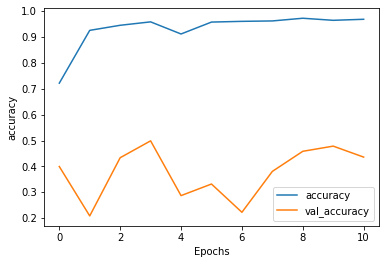

In [25]:
plot_graphs(history, 'accuracy')

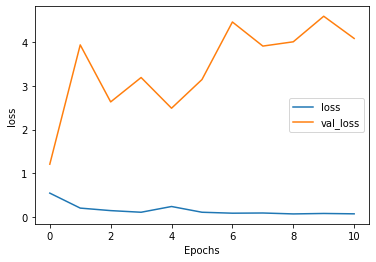

In [26]:
plot_graphs(history, 'loss')